## Model - Logistic Regression

In [1]:
import re
import os
import time
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from random import shuffle
import os
from sklearn.utils import shuffle
%matplotlib inline
import pickle as pkl
from sklearn.feature_selection import chi2

## Get Saved Data

In [16]:
train_text = pkl.load(open(os.path.join("../data", "train_text.p"), "rb"))
val_text = pkl.load(open(os.path.join("../data", "val_text.p"), "rb"))
test_text = pkl.load(open(os.path.join("../data", "test_text.p"), "rb"))
train_target = pkl.load(open(os.path.join("../data", "train_target.p"), "rb"))
val_target = pkl.load(open(os.path.join("../data", "val_target.p"), "rb"))
test_target = pkl.load(open(os.path.join("../data", "test_target.p"), "rb"))
label_mapping = pkl.load(open(os.path.join("../data", "target_mapping.p"), "rb"))

## Tranform labels

In [50]:
from sklearn import preprocessing
encoder = preprocessing.LabelBinarizer()
encoder.fit_transform(train_target)
y_train_encoded = encoder.transform(train_target)
y_val_encoded = encoder.transform(val_target)
y_test_encoded = encoder.transform(test_target)

In [51]:
num_class = len(encoder.classes_)

In [58]:
y_train_encoded[0]

array([0, 1, 0, 0, 0])

In [56]:
train_target[0]

1

## Transform Text

In [8]:
tfidf = TfidfVectorizer()

In [9]:
tfidf_xtrain = tfidf.fit_transform(train_text)
tfidf_xval = tfidf.transform(val_text)
tfidf_xtest = tfidf.transform(test_text)

In [11]:
xtrain_features = tfidf_xtrain.toarray()

We can see that, from 1571 sentences, we were able to get 31357 features, each feature is a word. 

In order to find terms mostly correlated with each of the label group, we can use chi2

In [17]:
label_mapping

{' Cardiovascular / Pulmonary': 0,
 ' Consult - History and Phy.': 1,
 ' Orthopedic': 2,
 ' Radiology': 3,
 ' Surgery': 4}

In [24]:
N = 2
for specialty, category_id in sorted(label_mapping.items()):
    features_chi2 = chi2(xtrain_features, train_target == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    print("# '{}':".format(specialty))
    print(" Most {} correlated unigrams:\n. {}".format(N, '\n. '.join(unigrams[-N:])))
    #print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# ' Cardiovascular / Pulmonary':
 Most 2 correlated unigrams:
. coronary
. artery
# ' Consult - History and Phy.':
 Most 2 correlated unigrams:
. history
. she
# ' Orthopedic':
 Most 2 correlated unigrams:
. knee
. fracture
# ' Radiology':
 Most 2 correlated unigrams:
. exam
. images
# ' Surgery':
 Most 2 correlated unigrams:
. is
. was


## Model Training and Selection

In [31]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log',
                    penalty='l2',
                    alpha=1e-5,
                    random_state=42,
                    max_iter=50,
                    tol=None,
                    early_stopping = False)


In [32]:
clf.fit(tfidf_xtrain, train_target)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

## Predict

In [33]:
y_pred_val = clf.predict_proba(tfidf_xval)

## Evaluation

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
def calculate_ROC(y_pred, y_true_encoded, num_class): 
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_class): 
        fpr[i], tpr[i], _ = roc_curve(y_true_encoded[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

In [65]:
def plot_ROC(fpr, tpr, roc_auc, label_mapping): 
    # cat_list: list of categories we want to plot 
    for specialty, i in label_mapping.items():
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for {}'.format(key))
        plt.legend(loc="lower right")
        plt.show()

In [66]:
fpr_val, tpr_val, roc_auc_val = calculate_ROC(y_pred=y_pred_val,
                                              y_true_encoded=y_val_encoded,
                                              num_class=num_class) 

In [63]:
roc_auc_val

{0: 0.9361209964412812,
 1: 0.9879378455727045,
 2: 0.9219077618543812,
 3: 0.9747550020416496,
 4: 0.9419171220400728}

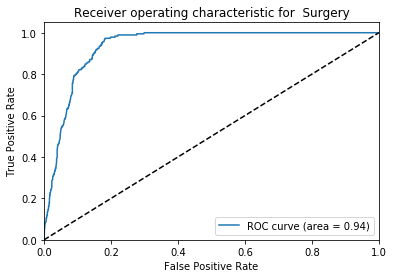

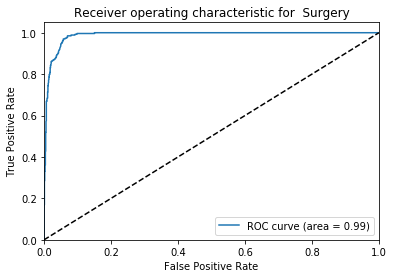

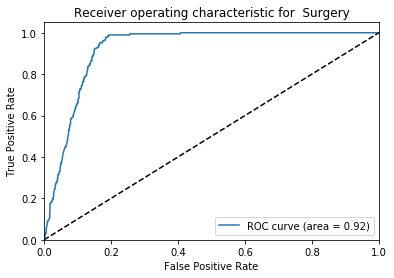

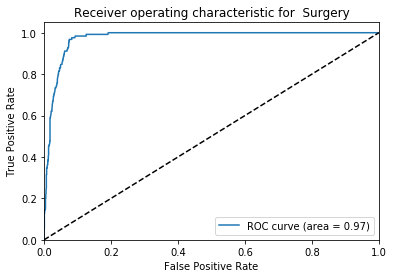

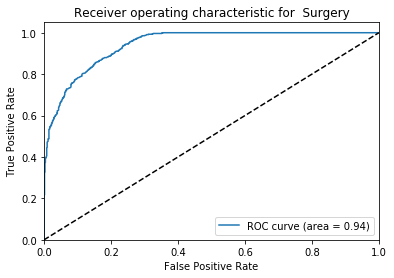

In [67]:
plot_ROC(fpr_val, tpr_val, roc_auc_val, label_mapping)

In [68]:
y_pred_test = clf.predict_proba(tfidf_xtest)

In [69]:
fpr_test, tpr_test, roc_auc_test = calculate_ROC(y_pred=y_pred_test,
                                              y_true_encoded=y_test_encoded,
                                              num_class=num_class) 

In [70]:
roc_auc_test

{0: 0.9268479673906316,
 1: 0.9896320754716981,
 2: 0.9271852425180598,
 3: 0.9803340096769158,
 4: 0.9346217026722443}